# Streaming Patchwork Builder

This notebook presents features of `StreamingPatchworkBuilder` which is a class designed for stitching multiple stripes of images and return part of resulting image as soon as it is fixed. It is opposite to `PatchworkBuilder` which returns complete patchwork on calling `get` method.

## Demo data
Demo data is defived from image below, by cutting, blurring and mapping pixel values.

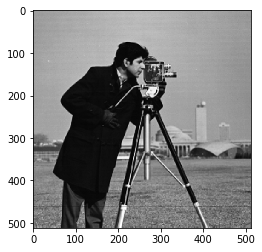

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import data

plt.imshow(data.camera(), cmap='gray')
plt.show()

Stripes derived from this image look as follows. Each row of images single stripe. Images in one row represent different z-axis. They differ slightly by blur. Images in rows are shifted horizontally to simulate real conditions.

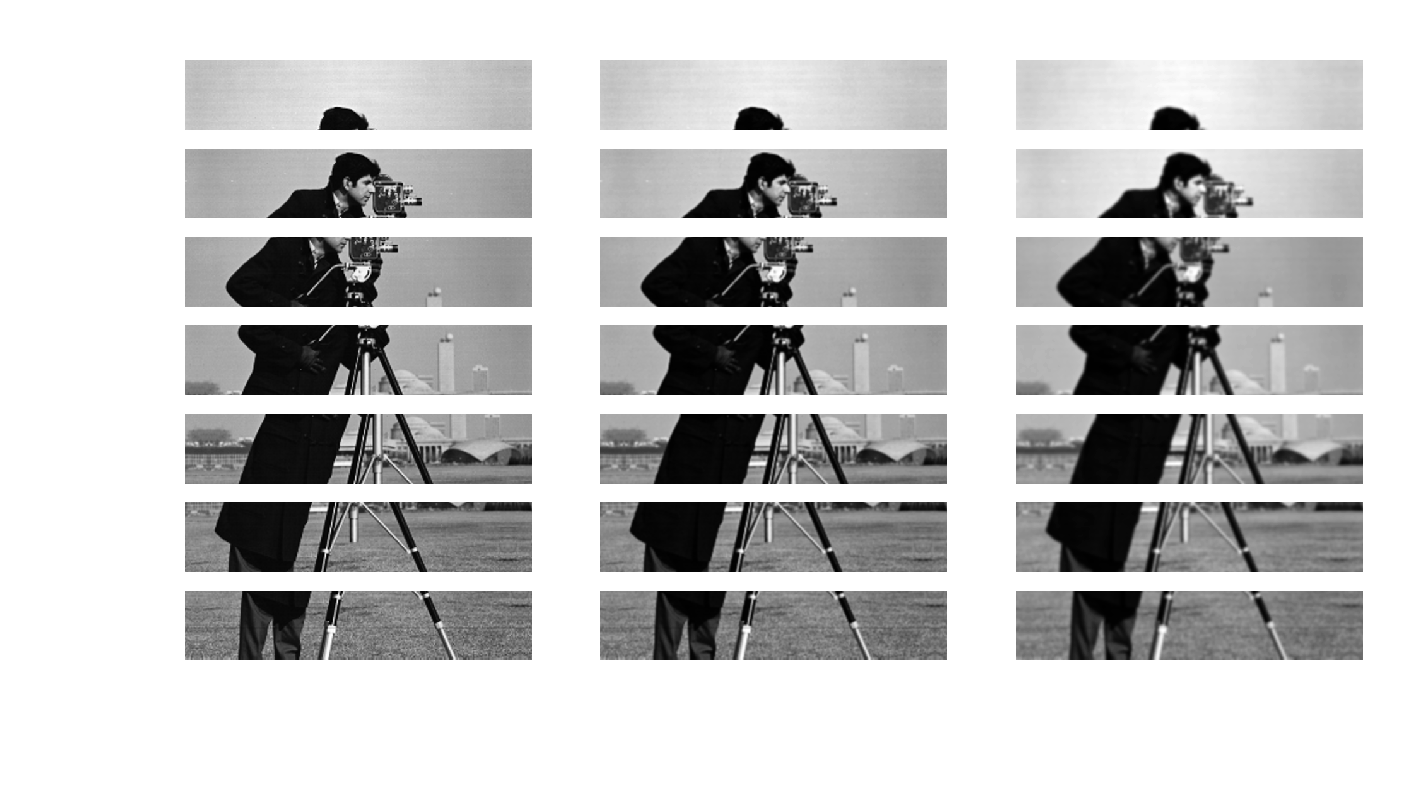

In [6]:
from alpenglow.demo_image_source import DemoImageSource

stripe_count = 7
version_count = 3
image_source = DemoImageSource(stripe_count=stripe_count, version_count=version_count, 
                               vertical_shifts=(19, 38, 0), overlap=0.4)

fig = plt.figure(figsize=(3.8, 2), dpi=400)
    
for version_id in range(version_count):
    for stripe_id in range(stripe_count):
        ax = fig.add_subplot(stripe_count, version_count, 1 + version_id + version_count * stripe_id)
        ax.imshow(image_source.get_image(stripe_id, version_id), cmap='gray')
        ax.set_axis_off()
plt.show()

Code below shows parts of the resulting image returned after feeding the `StreamingPatchworkBuilder` with consecutive rows of data.

After stripe 0 0 rows were ready
After stripe 1 111 rows were ready


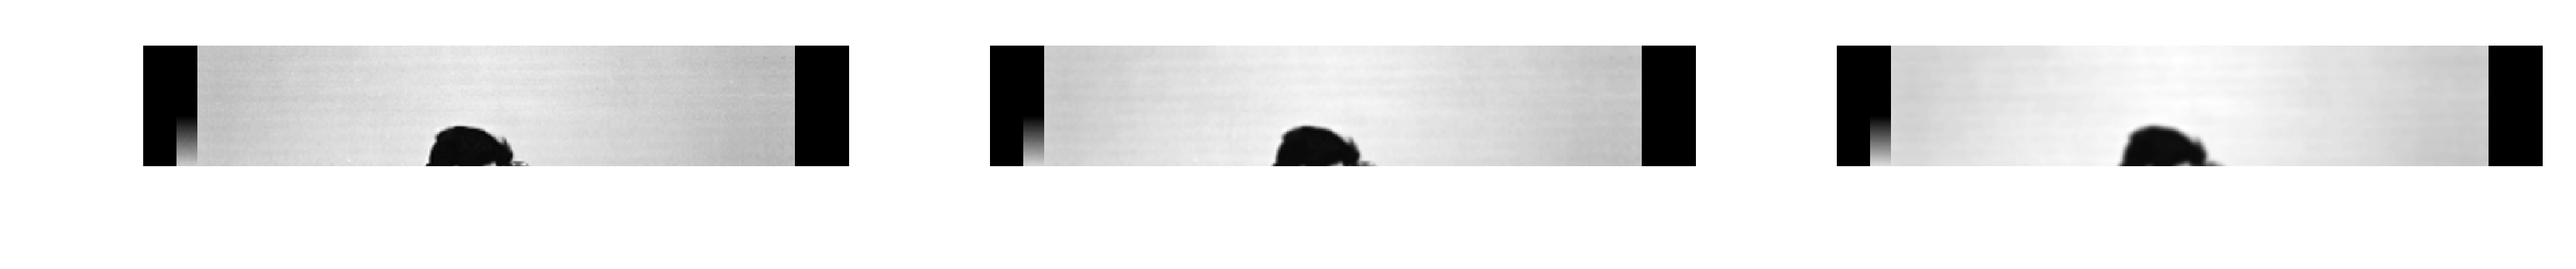

After stripe 2 65 rows were ready


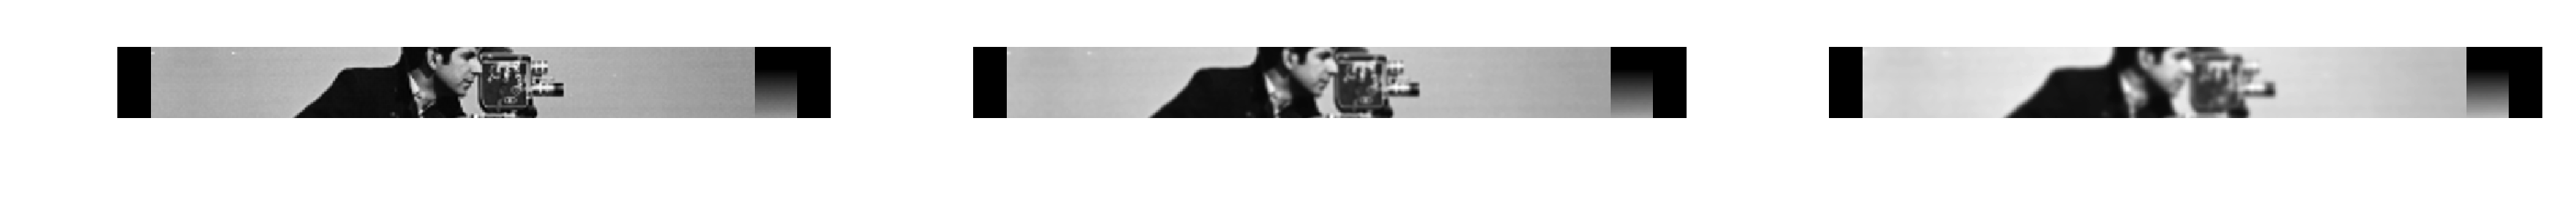

After stripe 3 67 rows were ready


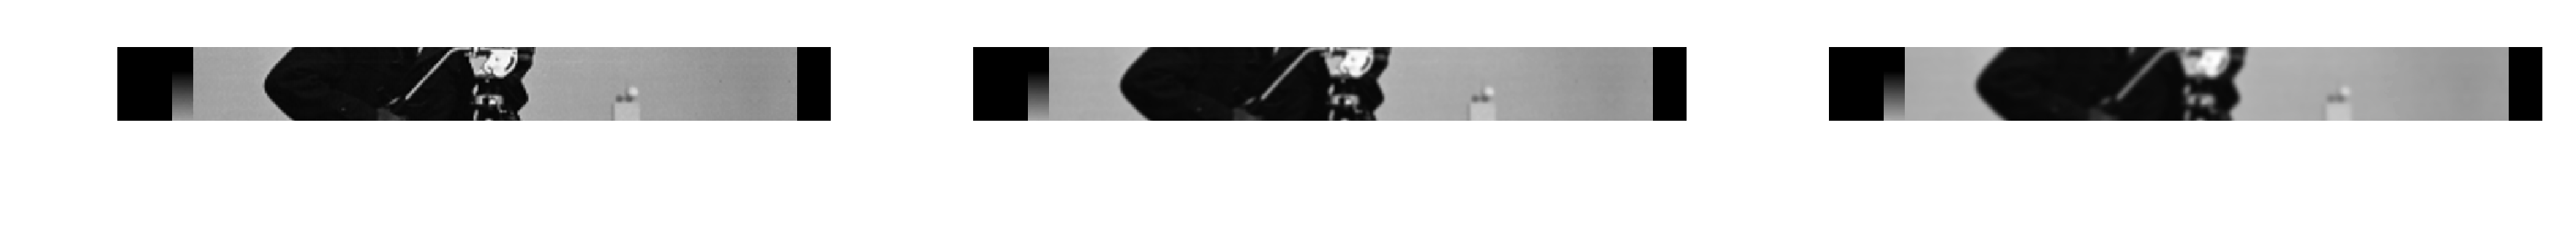

After stripe 4 66 rows were ready


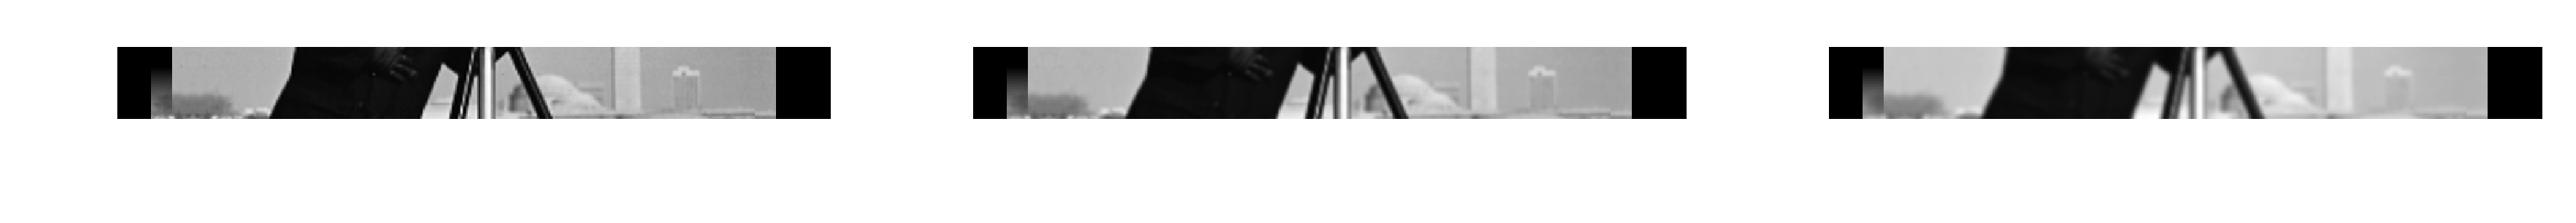

After stripe 5 64 rows were ready


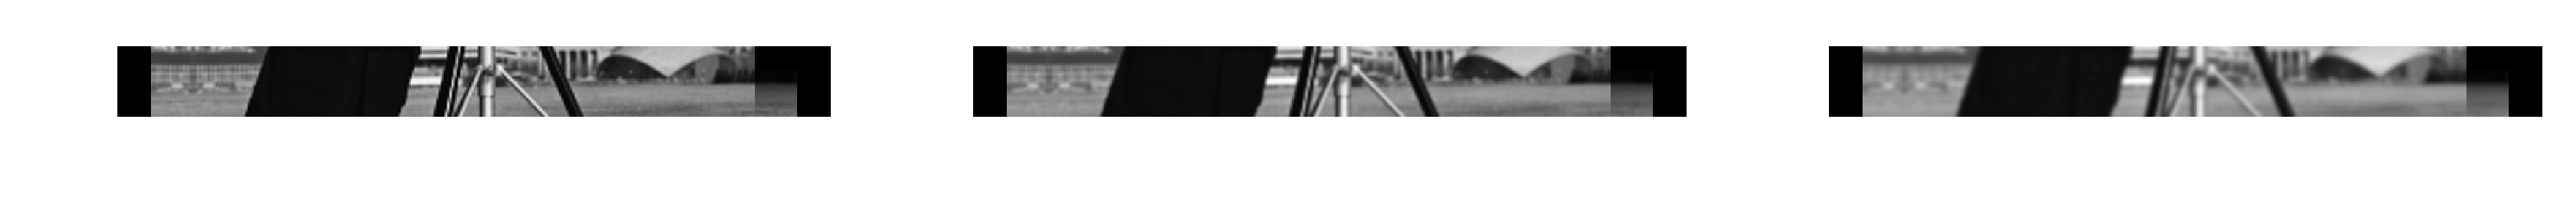

After stripe 6 66 rows were ready


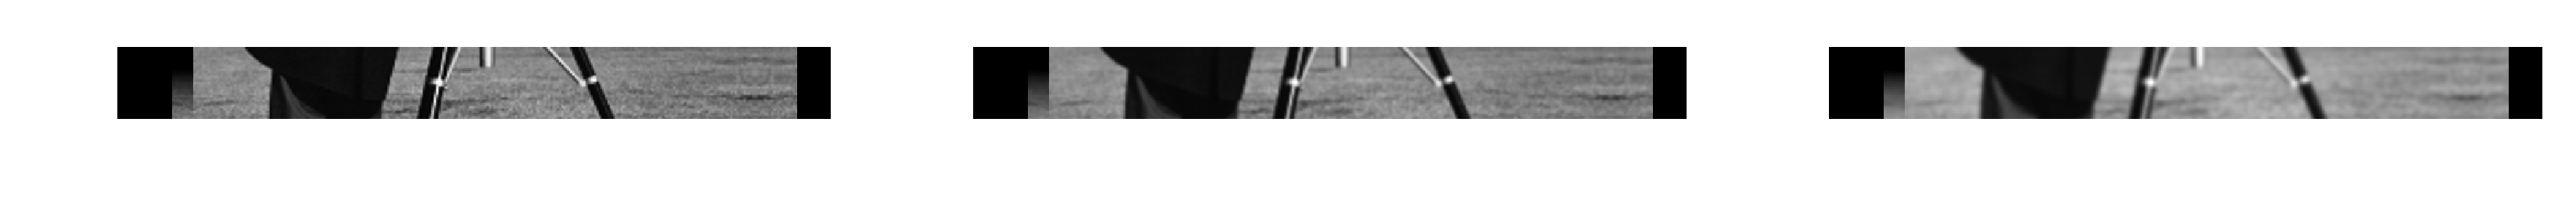

66 rows were available at the end


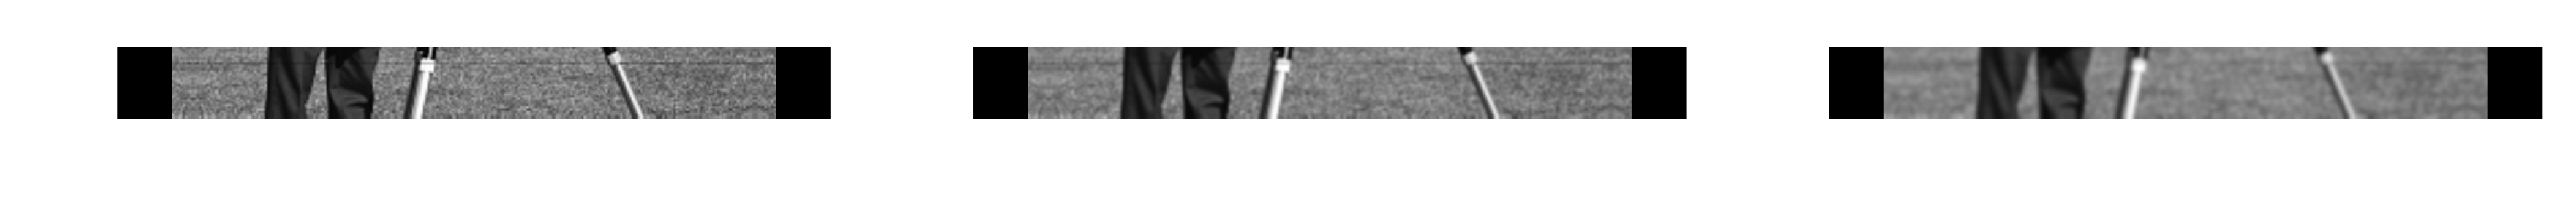

By simply conncating rows from this images we get the full picture (possibly with some black margins)


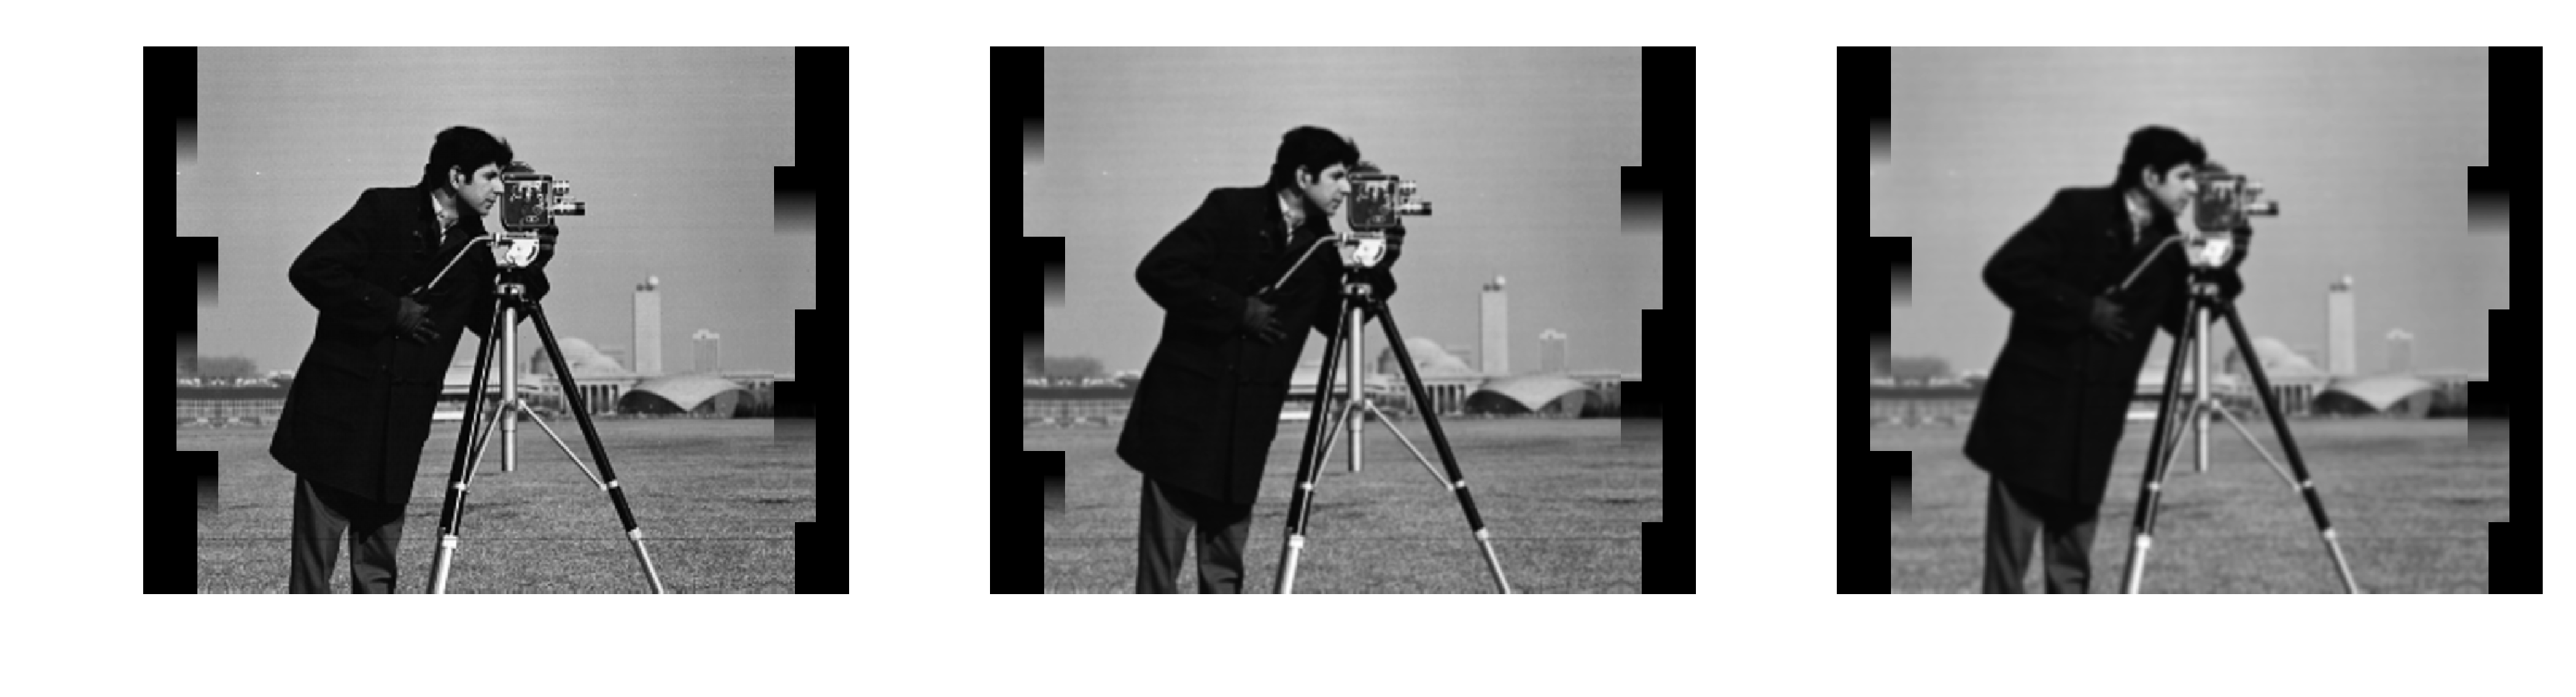

benchmarks
stitching times: [0.031816959381103516, 0.16707992553710938, 0.16347312927246094, 0.17865896224975586, 0.1735978126525879, 0.1718299388885498, 0.1770038604736328]
result building times: [0.19353389739990234, 0.09578704833984375, 0.0970761775970459, 0.09646105766296387, 0.09803485870361328, 0.10088324546813965, 0.00010800361633300781]


In [7]:
from alpenglow.fft_matching_algorithm import FftMatchingAlgorithm
matching_algorithm = FftMatchingAlgorithm([0, 2], [0,])

from alpenglow.streaming_patchwork_builder import StreamingPatchworkBuilder
builder = StreamingPatchworkBuilder(matching_algorithm, margin=50)

rows = []

for stripe_id in range(stripe_count):
    data = builder.stitch(image_source.get_stripe(stripe_id))
    
    rows_ready = data.get_image(0).shape[0]
    print("After stripe {0} {1} rows were ready".format(stripe_id, rows_ready))
    
    if rows_ready > 0:
        rows.append(data)
        fig = plt.figure(figsize=(10, 1), dpi=400)
    
        for version_id in range(version_count):
            ax = fig.add_subplot(1, version_count, 1 + version_id)
            ax.imshow(data.get_image(version_id), cmap='gray')
            ax.set_axis_off()
        plt.show()
        
data = builder.get()

rows_ready = data.get_image(0).shape[0]
print("{0} rows were available at the end".format(rows_ready))

if rows_ready > 0:
    rows.append(data)
    fig = plt.figure(figsize=(10, 1), dpi=400)

    for version_id in range(version_count):
        ax = fig.add_subplot(1, version_count, 1 + version_id)
        ax.imshow(data.get_image(version_id), cmap='gray')
        ax.set_axis_off()
    plt.show()
    
print("By simply conncating rows from this images we get the full picture (possibly with some black margins)")
fig = plt.figure(figsize=(10, 3), dpi=400)

import numpy
for version_id in range(version_count):
    image = numpy.concatenate([data.get_image(version_id) for data in rows])
    ax = fig.add_subplot(1, version_count, 1 + version_id)
    ax.imshow(image, cmap='gray')
    ax.set_axis_off()
plt.show()
    
stitching_times, result_building_times = builder.benchmark()
print("benchmarks\nstitching times: {0}\nresult building times: {1}".format(stitching_times, result_building_times))
